In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn.widgets import plt

# Veri dosyalarının yollarını belirtin
dataset_path = "C:/Users/taydin/parkinsons_updrs.csv"
labels_path = "C:/Users/taydin/parkinsons_updrs.names"

dataset = pd.read_csv(dataset_path)

print(dataset)





      subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0            1   72    0     5.6431       28.199       34.398    0.00662   
1            1   72    0    12.6660       28.447       34.894    0.00300   
2            1   72    0    19.6810       28.695       35.389    0.00481   
3            1   72    0    25.6470       28.905       35.810    0.00528   
4            1   72    0    33.6420       29.187       36.375    0.00335   
...        ...  ...  ...        ...          ...          ...        ...   
5870        42   61    0   142.7900       22.485       33.485    0.00406   
5871        42   61    0   149.8400       21.988       32.988    0.00297   
5872        42   61    0   156.8200       21.495       32.495    0.00349   
5873        42   61    0   163.7300       21.007       32.007    0.00281   
5874        42   61    0   170.7300       20.513       31.513    0.00282   

      Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0        

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ucimlrepo import fetch_ucirepo
parkinsons_telemonitoring = fetch_ucirepo(id=189)

X = parkinsons_telemonitoring.data.features
y = parkinsons_telemonitoring.data.targets["total_UPDRS"]
ids = parkinsons_telemonitoring.data.ids



train_idx, test_idx = train_test_split(pd.unique(ids["subject#"]), test_size=0.2, random_state=42)
X_train = X.loc[ids["subject#"].isin(train_idx)]
X_test = X.loc[ids["subject#"].isin(test_idx)]
y_train = y.loc[ids["subject#"].isin(train_idx)]
y_test = y.loc[ids["subject#"].isin(test_idx)]

# Modellerin ve isimlerinin bir sözlükte toplanması
models = {
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    "Lasso Regression": Lasso()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} MSE: {mse}")


SVR MSE: 91.71106232931177
KNN MSE: 150.13925653637702
Lasso Regression MSE: 120.61525955479934


In [4]:
import matplotlib.pyplot as plt

# Model isimleri ve hata kareleri
model_names = list(models.keys())
mse_values = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Çubuk grafik oluşturma
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Errors for Different Regression Models')
plt.xticks(rotation=45)
plt.show()


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from ucimlrepo import fetch_ucirepo

# Veri kümesini yükleme
parkinsons_telemonitoring = fetch_ucirepo(id=189)
X = parkinsons_telemonitoring.data.features
y = parkinsons_telemonitoring.data.targets["total_UPDRS"]
ids = parkinsons_telemonitoring.data.ids

# Dış döngü için çapraz doğrulama oluşturma
outer_cv = GroupKFold(n_splits=5)

# İç döngü için çapraz doğrulama oluşturma
inner_cv = GroupKFold(n_splits=3)

# Modellerin ve isimlerinin bir sözlükte toplanması
models = {
    "SVR": SVR(),
    "Lasso Regression": Lasso(),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor()  # Random Forest Regresyon modeli eklendi
}

for name, model in models.items():
    print(f"Evaluating {name}...")
    mse_scores = []
    if name == "Lasso Regression":
        param_grid = {'alpha': [0.1, 1, 10, 100]}  # Lasso için alfa hiperparametreleri
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=inner_cv)
        for train_index, test_index in outer_cv.split(X, y, groups=ids["subject#"]):
            X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
            y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

            grid_search.fit(X_train_outer, y_train_outer, groups=ids["subject#"].iloc[train_index])
            best_model = grid_search.best_estimator_

            y_pred = best_model.predict(X_test_outer)
            mse = mean_squared_error(y_test_outer, y_pred)
            mse_scores.append(mse)
    else:
        for train_index, test_index in outer_cv.split(X, y, groups=ids["subject#"]):
            X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
            y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train_outer, y_train_outer)
            y_pred = model.predict(X_test_outer)
            mse = mean_squared_error(y_test_outer, y_pred)
            mse_scores.append(mse)

    avg_mse = np.mean(mse_scores)
    print(f"{name} Average MSE: {avg_mse}")


Evaluating SVR...
SVR Average MSE: 112.41535386308105
Evaluating Lasso Regression...
Lasso Regression Average MSE: 114.20383099685391
Evaluating KNN...
KNN Average MSE: 173.7280850485881
Evaluating Random Forest...
Random Forest Average MSE: 184.6624701870877


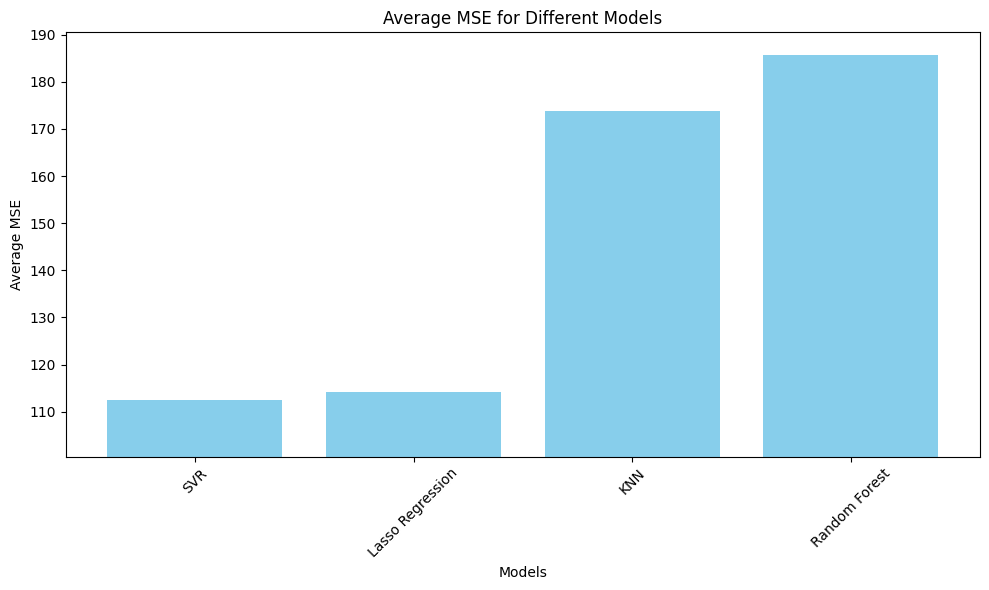

In [ ]:
import matplotlib.pyplot as plt

# Model isimleri ve ortalama MSE değerleri
model_names = ["SVR", "Lasso Regression", "KNN", "Random Forest"]
avg_mse_values = [112.41, 114.20, 173.72, 185.76]  # Bu değerler kod çıktısından alınmıştır

# Çubuk grafik oluşturma
plt.figure(figsize=(10, 6))
plt.bar(model_names, avg_mse_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Average MSE')
plt.title('Average MSE for Different Models')
plt.ylim(100.5, 190.5)  # Y ekseninin limitini ayarlayabilirsiniz
plt.xticks(rotation=45)  # Model isimlerini eğik olarak göstermek için
plt.tight_layout()

# Grafik gösterme veya kaydetme
plt.show()


  0%|          | 0/1235 [00:00<?, ?it/s]

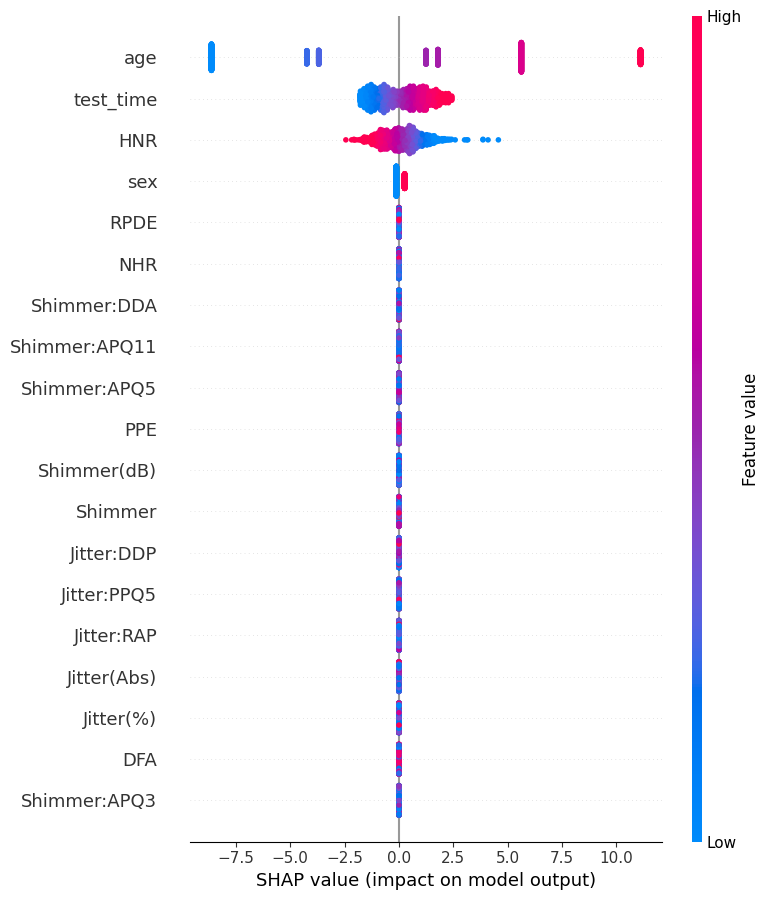

In [5]:
import shap
from sklearn.linear_model import Lasso

# Lasso modelini eğitin
model = Lasso(alpha=0.1)  # Örnek bir alpha değeri kullanıldı, siz kendi alpha değerinizi kullanmalısınız
model.fit(X_train, y_train)

# SHAP değerlerini hesaplamak için arka plan verisini özetleyin
shap_background = shap.sample(X, 100)  # 100 örnek için arka plan verisi özeti
explainer = shap.KernelExplainer(model.predict, shap_background)
shap_values = explainer.shap_values(X_test)

# SHAP değerlerini görselleştirin
shap.summary_plot(shap_values, X_test)

